In [1]:
import os
def homePath(path):
    if path[0] == "~":
        return os.path.join(os.path.expanduser("~"), path.strip("~/"))
    else:
        return path

#Model Creation 1
#Figure out how to do versioning effectively
individualInput = False
combinedInputPath = "/mnt/SPDrive/SPGenerations/"
pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"
GradesTokensName = ""


if not individualInput:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")

if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)





modelOutputPath = "/mnt/SPDrive/SPGenerations/Models/"



In [2]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os



#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

#load the group data
with open(pathToTokenizedData + "/tokenGroupDataframe.pkl", "rb") as f:
    tokenizedGroupData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
combinedDF = pd.merge(combinedDF, tokenizedGroupData, on = "Path")
print (combinedDF)







2023-11-14 03:50:47.932687: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 03:50:47.967055: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-14 03:50:47.967076: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-14 03:50:47.967099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-14 03:50:47.973730: I tensorflow/core/platform/cpu_feature_g

                                                tokenCode  \
0       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
1       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
2       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
3       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
4       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
...                                                   ...   
181281  [45, 287, 29, 287, 29, 1, 29, 276, 45, 1, 29, ...   
181282  [29, 687, 45, 287, 29, 287, 29, 1, 29, 276, 45...   
181283  [45, 287, 29, 287, 29, 1, 29, 276, 45, 1, 29, ...   
181284  [45, 287, 29, 287, 29, 1, 29, 276, 45, 1, 29, ...   
181285  [29, 687, 45, 287, 29, 287, 29, 1, 29, 276, 45...   

                                                     Path  fileGrade  \
0       3722273/examples/basics/linear_regression.py/1.py  59.000000   
1       3722273/examples/basics/linear_regression.py/3.py  67.000000   
2       3722273/examples/basics/linear_regression.p

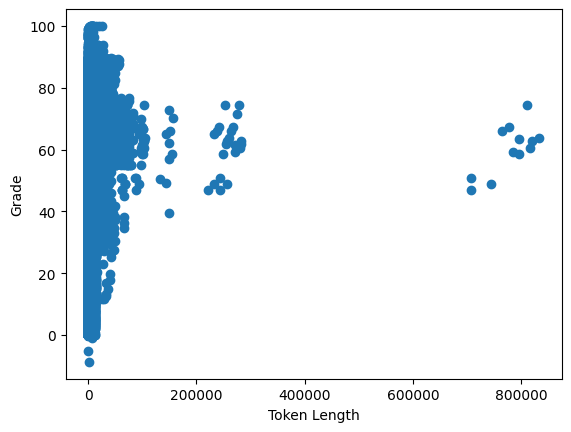

In [3]:
#chart of token length vs grade
tokenLengths = combinedDF["tokenCode"].apply(lambda x: len(x))
plt.scatter(tokenLengths, combinedDF["fileGrade"])
plt.xlabel("Token Length")
plt.ylabel("Grade")
plt.show()


#graph the density of the grades vs length
count = []
countLow = []
countHigh = []
for i in range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1):
    count.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].mean())
    countLow.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.25))
    countHigh.append(combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) == i]["fileGrade"].quantile(.75))

                 

plt.scatter(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count)
#draw a line of best fit
z = np.polyfit(range(1, combinedDF["tokenCode"].apply(lambda x: len(x)).max() + 1), count, 1)
p = np.poly1d(z)
plt.xlabel("Token Length")
plt.ylabel("Grade")
plt.show()







In [3]:
#Padding

maxLen = 500
minLen = 100
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]
combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) <= maxLen]
 

#get rid of the ones that are too short
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) > minLen]
combinedDF = combinedDF[combinedDF["tokenGroupCode"].apply(lambda x: len(x)) > minLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()
combinedDF["tokenGroupCode"] = pad_sequences(combinedDF["tokenGroupCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)

#only use 5% of the dat
#combinedDF = combinedDF.sample(frac = 0.001, random_state = 1)

#48590 



                                                tokenCode  \
0       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
1       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
2       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
3       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
4       [19, 10, 19, 45, 434, 29, 620, 6, 748, 6, 649,...   
...                                                   ...   
181271  [45, 434, 29, 1, 29, 85, 4, 22, 9, 3, 10, 3, 4...   
181275  [45, 434, 29, 1, 4, 22, 9, 3, 10, 3, 4, 25, 9,...   
181277  [45, 434, 29, 1, 4, 22, 9, 3, 10, 3, 4, 25, 9,...   
181278  [45, 434, 29, 1, 29, 85, 4, 22, 9, 3, 10, 3, 4...   
181279  [45, 434, 29, 1, 29, 85, 4, 22, 9, 3, 10, 3, 4...   

                                                     Path  fileGrade  \
0       3722273/examples/basics/linear_regression.py/1.py  59.000000   
1       3722273/examples/basics/linear_regression.py/3.py  67.000000   
2       3722273/examples/basics/linear_regression.p

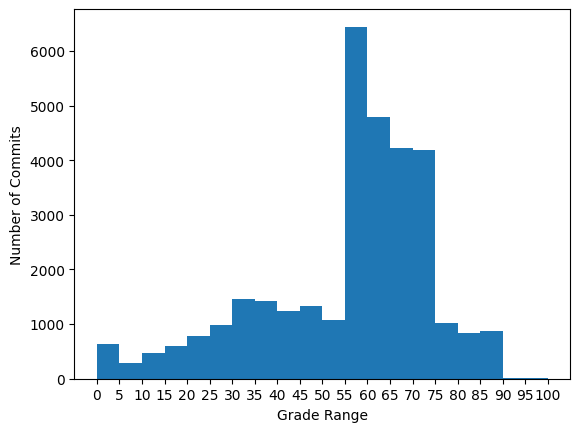

In [4]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [ ]:
#test to make sure gpu is detected and save as bool
gpu_detected = tf.test.is_gpu_available()


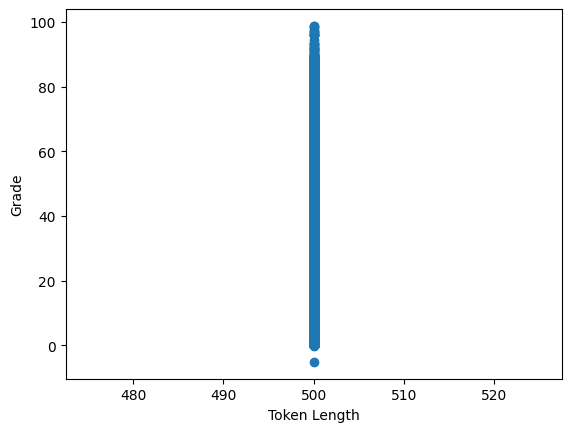

2023-11-14 03:51:18.194761: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13173 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:11:00.0, compute capability: 8.6
2023-11-14 03:51:18.195762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13173 MB memory:  -> device: 1, name: NVIDIA A2, pci bus id: 0000:b1:00.0, compute capability: 8.6
2023-11-14 03:51:29.514334: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 500, 50)              40000     ['input_2[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 500, 1024)            819200    ['input_1[0][0]']             
                                                                                              

2023-11-14 03:51:51.631236: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-14 03:51:52.262781: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 03:51:55.185670: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6bc43fa250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 03:51:55.185691: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A2, Compute Capability 8.6
2023-11-14 03:51:55.185695: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A2, Compute Capability 8.6
2023-11-14 03:51:55.189756: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 03:51:55.288388: I ./tensorflow/compiler/jit/device_compiler.h:186] Co

1012/1012 [==============================] - 252s 234ms/step - loss: 0.4295 - mse: 433.2386 - mae: 17.0496 - mape: 471515744.0000 - accuracy: 5.5592e-04
Epoch 2/100
1012/1012 [==============================] - 231s 228ms/step - loss: 0.3062 - mse: 345.8179 - mae: 15.0569 - mape: 279730816.0000 - accuracy: 0.0019
Epoch 3/100
1012/1012 [==============================] - 231s 228ms/step - loss: 0.2399 - mse: 284.4735 - mae: 13.4310 - mape: 165806880.0000 - accuracy: 0.0027
Epoch 4/100
1012/1012 [==============================] - 231s 228ms/step - loss: 0.2218 - mse: 268.1311 - mae: 12.9687 - mape: 142422416.0000 - accuracy: 0.0027
Epoch 5/100
1012/1012 [==============================] - 231s 228ms/step - loss: 0.2123 - mse: 249.1333 - mae: 12.4305 - mape: 128933048.0000 - accuracy: 0.0032
Epoch 6/100
1012/1012 [==============================] - 231s 228ms/step - loss: 0.1865 - mse: 235.2824 - mae: 12.0482 - mape: 98762680.0000 - accuracy: 0.0020
Epoch 7/100
1012/1012 [====================

/home/mcall/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
tar: Removing leading `/' from member names
tar: Removing leading `/home/mcall/SPGit/Model-Generation/../' from member names


/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/TokenizerManager.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/CaMlSupportingClasses.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/PythonProcessing.py
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CaMlSupportingClasses.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/CodeSimilarization.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/PythonProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/__pycache__/TokenProcessing.cpython-310.pyc
/home/mcall/SPGit/Model-Generation/SCA-Tokenizer/SupportingClasses/TokenProcessing.py
/home/mcall/SP

KeyError: 'val_loss'

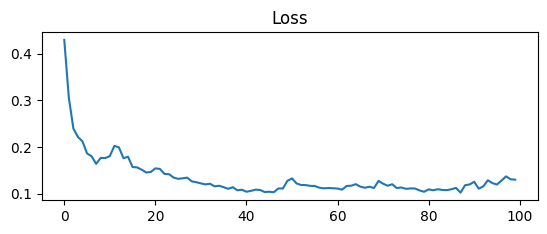

In [4]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")

#Create the model
#Input
inputTokens = layers.Input(shape=(maxLen,), dtype='int32')
inputGroupTokens = layers.Input(shape=(maxLen,), dtype='int32')


#Embedding
embedding = Embedding(tokenizer.num_words, 1024, input_length=maxLen)(inputTokens)
embeddingGroup = Embedding(tokenizer.num_words, 50, input_length=maxLen)(inputGroupTokens)

#Convolutional Layer
convolution = layers.Conv1D(2048, 3, activation='relu')(embedding)
convolutionGroup = layers.Conv1D(1024, 3, activation='relu')(embeddingGroup)

#Pooling Layer
pooling = layers.GlobalMaxPooling1D()(convolution)
poolingGroup = layers.GlobalMaxPooling1D()(convolutionGroup)

#Reshape
reshape = layers.Reshape((1, 2048))(pooling)
reshapeGroup = layers.Reshape((1, 1024))(poolingGroup)


#LSTM
lstm = layers.Bidirectional(LSTM(2048, return_sequences=True))(reshape)
lstm2 = layers.Bidirectional(LSTM(512, return_sequences=True))(reshapeGroup)

#Dropout
dropout2 = layers.Dropout(0.5)(lstm2)

#combine the two
combined = layers.Concatenate()([lstm, dropout2])

#LSTM
lstm3 = layers.Bidirectional(LSTM(1024))(combined)

#Dropout
dropout3 = layers.Dropout(0.5)(lstm3)

#LSTM


#Flatten
flatten = layers.Flatten()(dropout3)

#Dense
dense = Dense(2048, activation='relu')(flatten)

#Output
output = Dense(1, activation='linear')(dense)

model = Model(inputs=[inputTokens, inputGroupTokens], outputs=output)



print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam', metrics=['mse', 'mae', 'mape', 'accuracy'])





# convert inputs to numpy arrays
token_code = np.array(combinedDF["tokenCode"].tolist())
token_group_code = np.array(combinedDF["tokenGroupCode"].tolist())
file_grade = np.array(combinedDF["fileGrade"].tolist())

hist = model.fit([token_code, token_group_code], file_grade, epochs=100, batch_size=32, verbose=1)


#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

#Save tokenizedGroupData
with open(modelOutputPath + "/" + timestamp + "/tokenizedGroupDataframe.pkl", "wb") as f:
    pickle.dump(tokenizedGroupData, f)



plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
#make an archaive of the SCA-Tokenizer Folder
#get CWD
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd, "SCA-Tokenizer")):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/SCA-Tokenizer.tar.gz\" " + os.path.join(cwd, "SCA-Tokenizer"))

#Save the AutoGrader Folder
autoGraderDir = os.path.join(cwd, "../Auto-Grader/")
if os.path.exists(autoGraderDir):
    os.system("tar -czvf \"" + modelOutputPath + "/" + timestamp + "/Auto-Grader.tar.gz\" " + autoGraderDir)

In [3]:
import os
timestamp = str(pd.Timestamp.now()).replace(" ", "_").replace(":", "-").replace(".", "-")
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)

In [12]:
# assuming `model` is your Keras model
#convert inputs to numpy arrays



[(None, 33), (None, 33)]
[29, 384, 45, 374, 29, 1, 6, 1, 45, 374, 5, 1, 29, 1, 7, 142, 6, 176, 8, 9, 7, 1, 5, 142, 6, 1, 5, 176, 8, 82, 30, 22, 7, 384, 5, 1, 8, 11, 2, 18, 14, 22, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 142, 6, 3, 10, 3, 8, 2, 2, 12, 5, 102, 7, 176, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 176, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 142, 6, 3, 10, 3, 8, 2, 2, 12, 5, 1, 7, 176, 6, 13, 8, 2, 2, 12, 5, 1, 7, 142, 6, 13, 8, 2, 2, 12, 5, 1, 7, 142, 6, 176, 8, 2, 18, 14, 25, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 1, 7, 176, 8, 6, 142, 8, 2, 2, 12, 5, 102, 7, 1, 7, 142, 8, 6, 176, 8, 2, 18, 14, 26, 7, 12, 8, 11, 2, 2, 12, 5, 330, 7, 125, 6, 1, 6, 3, 10, 3, 8, 2, 18, 14, 28, 7, 12, 8, 11, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 8, 8, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 142, 6, 8, 8, 2, 2, 12, 5, 102, 7, 1, 7, 3, 10, 3, 8, 6, 7, 142, 6, 176, 6, 176, 6, 142, 8, 8, 2, 18, 14, 31, 7, 12, 8, 11, 2, 2, 12, 5, 330, 7, 125, 6, 1, 6, 3, 10, 3, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 